# Predicting Voter Turnout by County in Arizona and Utah

### Members: Bochen Wang, Zack Reardon, Justing Pak, Shivani Kharva

In order for a political campaign to effectively allocate its available resources, it is imparative to consider which locations offer the highest potential return on their invsetment in the form of voting constituents. Staffing call centers, directing door-to-door campaign efforts, and choosing locations for candidate outreach are all predicated on the hope that voters in an area will come out and vote when the time comes. By looking at the history of voter turnout by county and assessing correlations between areas of high turnout and gender, age, and ethnicity, a campaign can better focus its efforts on swaying swing voters in high-turnout counties or promoting higher turnout in their favor in lower-turnout counties. Our aim, through various predictive models, is to help a campaign determine the likelihood of voter turnout in a county given these demographics, and assist them in planning their campaign accordingly. Essentially, we hope to predict the variable "ElectionReturns_P16CountyTurnoutAllRegisteredVoters" from the L2, Inc data with the highest accuracy we can, given the variables "Voters_Gender", "Voters_Age", and "EthnicGroups_EthnicGroup1Desc".

In conducting our EDA and defining our project goals, our group chose to explore the relationship between voter demographics such as ethnicity, education, gender, age, and location and the proportional voter turnout during presidential primary elections. Since the columns in the data for Arizona and Utah can be difficult to interpret, we honed in on two potential response variables that could be indicative of voter turnout. The variables we focused on were "Voters_Active" and election type columns for presidential primary elections of the form "PresidentialPrimary_XXXX", with "XXXX" replaced by the associated presidential election years between 2000 and 2020. "Voters_Active" took values of 'A', indicating that a voter was active, and 'I', indicating that a voter was inactive. The yearly election type columns referenced a voter's participation in the respective election with a 'Y' and a null value otherwise. In visualizing the proportion of 'A's in each given state's voter activity, we were able to calculate what we thought would represent the proportion of total voters registered for each election by state. The resulting 92+ percent voter registration rates seemed quite high, and we were able to draw slight correlations with this metric and demographics such as "Ethnic_Description" and "School_District"/"CommercialData_Education". We then proceded to assess voter turnout as the number of 'Y's indicated within each presidential primary election column, such as the variable "PresidentialPrimary_2000". While this should have been indicative of the number of people who voted in each election outright by state, after cleaning the data of "nulls", we were left with very small voter turnout rates for each presidential primary election by state (even some 0% values for Utah). These resulting turnout rates are obviously unrealistic, with the implication being that the yearly election type columns do not contain a significant amount of election participation data.

Ultimately, we settled on the response variable "ElectionReturns_PXXCountyTurnoutAllRegisteredVoters", with "XX" representing the year of the presidential election in question (i.e. 2008, 2012, 2016). This variable was able to alleviate some of the issues we had with the initial variables we explored in that it accounted for true election turnout rather than "activity", which was decidedly ambiguous. Additionally, It was free from missing values unlike the "PresidentialPrimary" variables. Intuitively, it seems that our new response variable is more official while "PresidentialPrimary" appeared to be self-reported. Furthermore, we honed in on "Voters_Gender", "Voters_Age", and "EthnicGroups_EthnicGroup1Desc" as our final demographic variables to consider.

# Preparing the Data

The first step in assessing and working with the data is to import it into Spark alongside the necessary libraries.

In [35]:
# Importing necessary libraries/functions
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.ml.feature import RFormula, OneHotEncoder, StringIndexer, VectorAssembler, VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml import Pipeline

In [2]:
from IPython import display

In [3]:
# Defining initial paths for our parquet files
states = ['VM2Uniform--AZ--2021-05-20', 'VM2Uniform--UT--2021-03-26']
gcs_path = 'gs://pstat135-voter-file/VM2Uniform'

Now that we have set the paths for our parquet files for Arizona and Utah, we can read them in as dataframes. Since our EDA exposed missing data in our predictor variables, we will have to deal with it accordingly. Since the amount of missing data in "Voters_Gender" and "Voters_Age" was relatively small for either state, less than a percent in each case, we determined that dropping the missing data wouldn't constitute a significant detriment to the amount of useable data on hand. Consequently, both the Arizona and Utah dataframes had missing gender and age data dropped once they were read into Spark. The amount of missing data in "EthnicGroups_EthnicGroup1Desc" was closer to 10% for both states, a figure we deemed to be significant. Since this ethnicity information was null, and ethnicity may be self-reported at the voter descretion, we decided to replace nulls with the value 'Undisclosed" since the voter did not disclose that information.

In [4]:
# Arizona data frame
AZ_df = spark.read.parquet("/".join([gcs_path, "VM2Uniform--AZ--2021-05-20"]))

# Unknown ethnicity replaced with undisclosed
AZ_df = AZ_df.na.fill(value="Undisclosed", subset=["EthnicGroups_EthnicGroup1Desc"])

# Removed mssing values for gender
AZ_df = AZ_df.filter(AZ_df["Voters_Gender"].isNotNull())

# Removed mssing values for age
AZ_df = AZ_df.filter(AZ_df["Voters_Age"].isNotNull())

In [5]:
# Utah data frame
UT_df = spark.read.parquet("/".join([gcs_path, "VM2Uniform--UT--2021-03-26"]))

# Unknown ethnicity replaced with undisclosed
UT_df = UT_df.na.fill(value="Undisclosed", subset=["EthnicGroups_EthnicGroup1Desc"])

# Removed mssing values for gender
UT_df = UT_df.filter(UT_df["Voters_Gender"].isNotNull())

# Removed mssing values for age
UT_df = UT_df.filter(UT_df["Voters_Age"].isNotNull())

Now that both dataframes are available and the data in question is cleaned, the categorical variables "EthnicGroups_EthnicGroup1Desc" and "Voters_Age" should be converted from string to a numeric type. This transition allows for them to be one hot encoded into dummy variables that can be used more effectively in the predictive modeling process.

In [6]:
# Preparing to convert categorical features to numeric for one hot encoding
indexer = StringIndexer(inputCols=["EthnicGroups_EthnicGroup1Desc", "Voters_Age"], outputCols=["EthnicGroupsNumeric", "AgeNumeric"])

# Converting categorical features to numeric in AZ_df
indexer_fitted_AZ = indexer.fit(AZ_df)
AZ_df_indexed = indexer_fitted_AZ.transform(AZ_df)

# Converting categorical features to numeric in UZ_df
indexer_fitted_UT = indexer.fit(UT_df)
UT_df_indexed = indexer_fitted_UT.transform(AZ_df)

Finally the indexed dataframes can be converted for modelling by having the numeric data for "EthnicGroups_EthnicGroup1Desc" and "Voters_Age" one hot encoded.

In [8]:
# Preparing to one hot encode categorical features
onehot = OneHotEncoder(inputCols=["EthnicGroupsNumeric", "AgeNumeric"], outputCols=["EthnicGroupsEncoded", "AgeEncoded"])

# One hot encoding categorical features in AZ_df
onehotAZ = onehot.fit(AZ_df_indexed)
AZ_df_onehot = onehotAZ.transform(AZ_df_indexed)

# One hot encoding categorical features in UT_df
onehotUT = onehot.fit(UT_df_indexed)
UT_df_onehot = onehotUT.transform(UT_df_indexed)

Since the columns "ElectionReturns_P16CountyTurnoutAllRegisteredVoters", "ElectionReturns_P12CountyTurnoutAllRegisteredVoters", and "ElectionReturns_P08CountyTurnoutAllRegisteredVoters" consist of strings with a trailing percentage sign, we will drop the percentage sign and convert the columns to integers. This means that "ElectionReturns_P12CountyTurnoutAllRegisteredVoters" and "ElectionReturns_P08CountyTurnoutAllRegisteredVoters" wouldn't have to be one hot encoded and "ElectionReturns_P16CountyTurnoutAllRegisteredVoters" can be predicted with continuous rather than discrete values.

In [9]:
from pyspark.sql.types import DoubleType

In [10]:
# Removing % in county turnout columns for AZ and converting to integers
AZ_df_onehot = AZ_df_onehot.withColumn("ElectionReturns_P16CountyTurnoutAllRegisteredVoters", F.regexp_replace("ElectionReturns_P16CountyTurnoutAllRegisteredVoters", "%", "").cast(DoubleType()))
AZ_df_onehot = AZ_df_onehot.withColumn("ElectionReturns_P12CountyTurnoutAllRegisteredVoters", F.regexp_replace("ElectionReturns_P12CountyTurnoutAllRegisteredVoters", "%", "").cast(DoubleType()))
AZ_df_onehot = AZ_df_onehot.withColumn("ElectionReturns_P08CountyTurnoutAllRegisteredVoters", F.regexp_replace("ElectionReturns_P08CountyTurnoutAllRegisteredVoters", "%", "").cast(DoubleType()))

# Removing % in county turnout columns for UT and converting to integers
UT_df_onehot = UT_df_onehot.withColumn("ElectionReturns_P16CountyTurnoutAllRegisteredVoters", F.regexp_replace("ElectionReturns_P16CountyTurnoutAllRegisteredVoters", "%", "").cast(DoubleType()))
UT_df_onehot = UT_df_onehot.withColumn("ElectionReturns_P12CountyTurnoutAllRegisteredVoters", F.regexp_replace("ElectionReturns_P12CountyTurnoutAllRegisteredVoters", "%", "").cast(DoubleType()))
UT_df_onehot = UT_df_onehot.withColumn("ElectionReturns_P08CountyTurnoutAllRegisteredVoters", F.regexp_replace("ElectionReturns_P08CountyTurnoutAllRegisteredVoters", "%", "").cast(DoubleType()))

Now that our data is of the correct type, we need to pivot the data so we may use the one-hot encoded columns as predictors.

In [11]:
# Pivoting the data for Arizona
AZ_df_new = AZ_df_onehot[['EthnicGroupsEncoded', 'AgeEncoded', 'Voters_Gender', 'ElectionReturns_P16CountyTurnoutAllRegisteredVoters', 'ElectionReturns_P12CountyTurnoutAllRegisteredVoters', 
                          'ElectionReturns_P08CountyTurnoutAllRegisteredVoters']]

# Pivoting the data for Utah
UT_df_new = UT_df_onehot[['EthnicGroupsEncoded', 'AgeEncoded', 'Voters_Gender', 'ElectionReturns_P16CountyTurnoutAllRegisteredVoters', 'ElectionReturns_P12CountyTurnoutAllRegisteredVoters', 
                          'ElectionReturns_P08CountyTurnoutAllRegisteredVoters']]

Let's take a look at our final schemas to make sure our variables are as they should be.

In [12]:
# Printing the schemas
AZ_df_new.printSchema()

UT_df_new.printSchema()

root
 |-- EthnicGroupsEncoded: vector (nullable = true)
 |-- AgeEncoded: vector (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- ElectionReturns_P16CountyTurnoutAllRegisteredVoters: double (nullable = true)
 |-- ElectionReturns_P12CountyTurnoutAllRegisteredVoters: double (nullable = true)
 |-- ElectionReturns_P08CountyTurnoutAllRegisteredVoters: double (nullable = true)

root
 |-- EthnicGroupsEncoded: vector (nullable = true)
 |-- AgeEncoded: vector (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- ElectionReturns_P16CountyTurnoutAllRegisteredVoters: double (nullable = true)
 |-- ElectionReturns_P12CountyTurnoutAllRegisteredVoters: double (nullable = true)
 |-- ElectionReturns_P08CountyTurnoutAllRegisteredVoters: double (nullable = true)



The two schemas are the same and look correct. Our data is finally ready for building our models to predict the voter turnout in 2016! 

# Model Building

To assess how well our models do, we will use the RMSE (Root Mean Squared Error) and $R^2$. The RMSE is a very widely used measure for evaluating the performance of regression models by using Euclidian distance to show how far a model’s predictions are from the true values. So, a lower RMSE is better since that means the predicted values have a smaller distance from the actual values. The $R^2$ value is a measurement for the proportion of the variation in the response (i.e. `ElectionReturns_P16CountyTurnoutAllRegisteredVoters` in our case) that is explained by the chosen explanatory variables. A higher $R^2$ is better because that means our chosen variables explain a greater proportion of our outcome. So, we will use these two values to assess performance of the models for each state and also to compare the performance of the models between states.

## Linear Regression

First, we will fit a linear regression model for each of the states. By fitting a linear regression model, we will attempt to describe the relationship between `ElectionReturns_P16CountyTurnoutAllRegisteredVoters` and our chosen explanatory variables using a straight line. Often, this model will not result in the best RMSE or $R^2$ unless the data is actually linear. Now, let us get to fitting the model!

Let us first create a general formula that can be used for both Utah and Arizona.

In [11]:
# Creating general RFormula that can be used for both Utah and Arizona
supervised = RFormula(formula = 'ElectionReturns_P16CountyTurnoutAllRegisteredVoters ~ .')

**Arizona**

Now, we fit and transform the formula on our data frame.

In [12]:
# Fitting the model on our data
fittedAZ = supervised.fit(AZ_df_new)

# Transforming our data frame
preparedAZ = fittedAZ.transform(AZ_df_new)

Using this data frame that has been transformed around the formula we specified, we will extract a training and testing set. We do this to train our model on some proportion of the data by fitting the model to that data. Then, instead of fitting on the testing set, we simply transform the model on that set of data to see how the model performs without being fit and trained on the data. This will give us a closer estimate of true performance of our linear regression model.

In [13]:
# Creating the training and testing data sets from the transformed model with a seed
trainAZ, testAZ = preparedAZ.randomSplit([0.7, 0.3], 135)

Now, let us actually define the linear regression model and fit it to the training data.

In [14]:
# Defining the linear regression object
lr_AZ = LinearRegression(labelCol="label", featuresCol="features")

# Fitting the linear regression model on the training data
lrModel_AZ = lr_AZ.fit(trainAZ)

23/03/19 23:10:50 WARN org.apache.spark.ml.util.Instrumentation: [4fe55be7] regParam is zero, which might cause numerical instability and overfitting.
23/03/19 23:11:50 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/19 23:11:50 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/03/19 23:11:51 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/03/19 23:11:51 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Since the linear regression model results in an estimated linear model for the data, we will have estimated coefficients for each of the explanatory variables. Some explanatory variables will have more importance than others. Those will have coefficients with greater absolute values than the coefficients of the other explanatory variables. We take absolute value because a high negative number still indicates feature importance, just in the negative direction. So, let us plot the absolute values of the coefficients to compare feature importance.

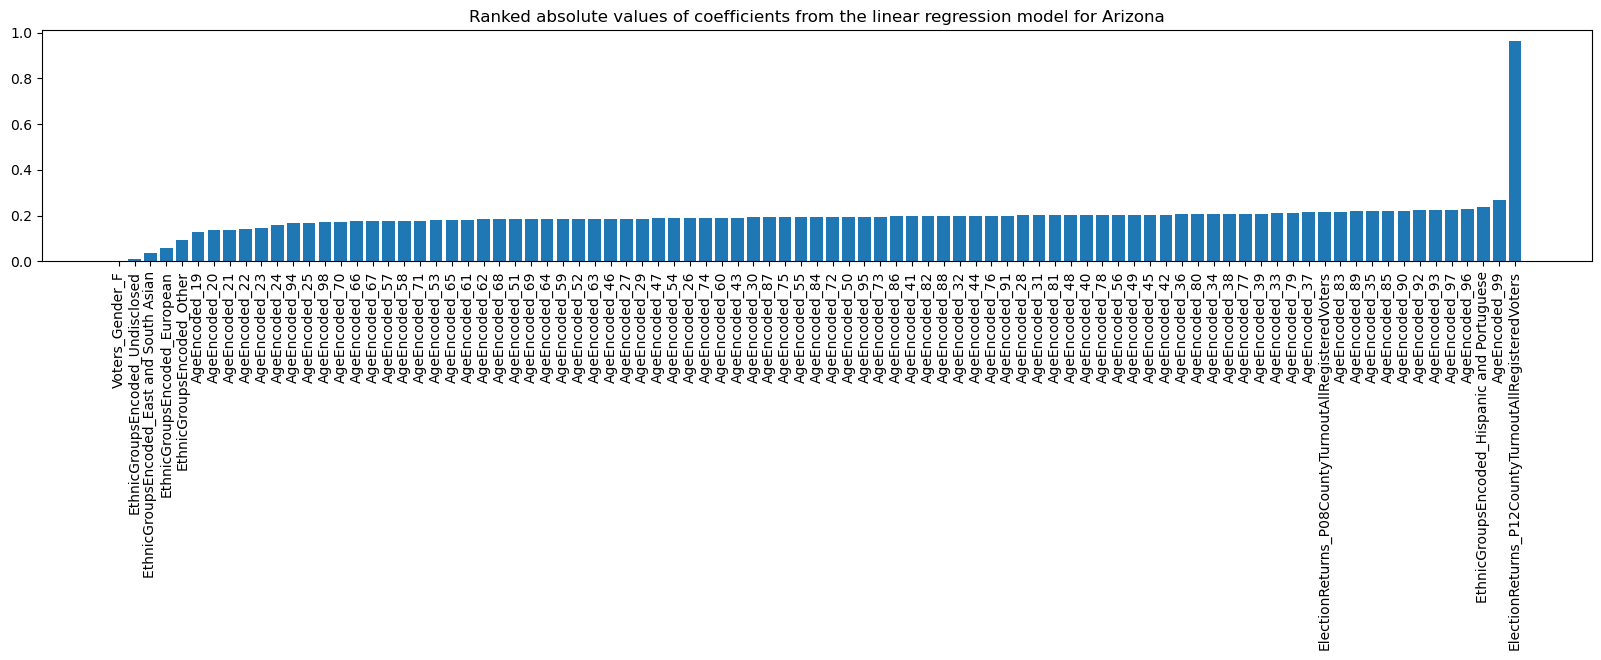

In [18]:
# Retrieving the name of the columns used to make our feature vector and storing them in a pandas DataFrame
featureCols_AZ = pd.DataFrame(preparedAZ.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  preparedAZ.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols_AZ = featureCols_AZ.set_index('idx')

# Creating a data frame of the coefficients
coefsArray_AZ = np.array(lrModel_AZ.coefficients)  # convert to np.array
coefsDF_AZ = pd.DataFrame(coefsArray_AZ, columns=['coefs'])  # to pandas
coefsDF_AZ = coefsDF_AZ.merge(featureCols_AZ, left_index=True, right_index=True)  # join it with featureCols we created above
coefsDF_AZ.sort_values('coefs', inplace=True)  # Sort them

# Taking the absolute values of the coefficients (to compare feature importance overall)
coefsDF2_AZ = coefsDF_AZ
coefsDF2_AZ['coefs'] = coefsDF2_AZ['coefs'].abs()
coefsDF2_AZ.sort_values('coefs', inplace=True)  # Sort them

# Plotting
plt.rcParams["figure.figsize"] = (20,3)

plt.xticks(rotation=90)
plt.bar(coefsDF2_AZ.name, coefsDF2_AZ.coefs)
plt.title('Ranked absolute values of coefficients from the linear regression model for Arizona')
plt.show() 

It appears the most important variable in predicting `ElectionReturns_P16CountyTurnoutAllRegisteredVoters` for Arizona is `ElectionReturns_P12CountyTurnoutAllRegisteredVoters`. Intuitively, this makes sense because, if a voter came to the previous major election (because these are the years where there was a presidential election), it would make sense for them to return to the next major election.

Before we test the model, let us check the model performance on the training data.

In [19]:
# Extracting the summary of our model
summary_AZ = lrModel_AZ.summary

# Extracting the rmse and r2 of the training data from the summary
LR_rmse_AZ_train = summary_AZ.rootMeanSquaredError
LR_r2_AZ_train = summary_AZ.r2

LR_rmse_AZ_train, LR_r2_AZ_train

(1.215821421899662, 0.8800626725292535)

The RMSE of 1.2158 is moderately low and the $R^2$ of 0.8801 is moderately high, so the model did relatively well on the training data. However, let us now test the model and compare its performance on the testing data to the training data.

In [20]:
# Testing the model
LRfittedTest_AZ = lrModel_AZ.transform(testAZ)

# Viewing the results of the top 5 rows
LRfittedTest_AZ['label', 'prediction'].show(5)

+-----+------------------+
|label|        prediction|
+-----+------------------+
| 24.0| 22.29417147034688|
| 24.0|23.909555683819622|
| 24.0|23.909555683819622|
| 24.0|23.909555683819622|
| 24.0|23.909555683819622|
+-----+------------------+
only showing top 5 rows



It appears the predictions are not too far off the true values, but let us check the RMSE and $R^2$ to verify.

In [22]:
# Setting the evaluator object
LRevaluator = RegressionEvaluator(labelCol = "ElectionReturns_P16CountyTurnoutAllRegisteredVoters",
                  predictionCol = "prediction")

# Finding the rmse and r2 of the model on the testing data
LR_rmse_AZ = LRevaluator.evaluate(LRfittedTest_AZ, {LRevaluator.metricName: "rmse"})
LR_r2_AZ = LRevaluator.evaluate(LRfittedTest_AZ, {LRevaluator.metricName: "r2"})

print(LR_rmse_AZ, LR_r2_AZ)

1.2141175530461816 0.8801225447298408


It appears the RMSE and $R^2$ of the model on the testing data were in the same range as that of the training data. The RMSE of 1.2141 is still moderately low and the $R^2$ of 0.8801 is still moderately high.

**Utah**

Now, we fit and transform the formula on our data frame for Utah (repeating the same steps as we did for Arizona).

In [23]:
# Fitting the model on our data
fittedUT = supervised.fit(UT_df_new)

# Transforming our data frame
preparedUT = fittedUT.transform(UT_df_new)

Next, we extract the training and testing sets for Utah.

In [24]:
# Creating the training and testing data sets from the transformed model with a seed
trainUT, testUT = preparedUT.randomSplit([0.7, 0.3], 135)

Now, defining the linear regression model and fitting on the training data for Utah.

In [25]:
# Defining the linear regression object
lr_UT = LinearRegression(labelCol="label", featuresCol="features")

# Fitting the linear regression model on the training data
lrModel_UT = lr_UT.fit(trainUT)

23/03/19 23:34:54 WARN org.apache.spark.ml.util.Instrumentation: [6ba7bc56] regParam is zero, which might cause numerical instability and overfitting.
23/03/19 23:35:51 WARN org.apache.spark.ml.util.Instrumentation: [6ba7bc56] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Next, let us create the same plot of coefficient absolute values as we did for Arizona.

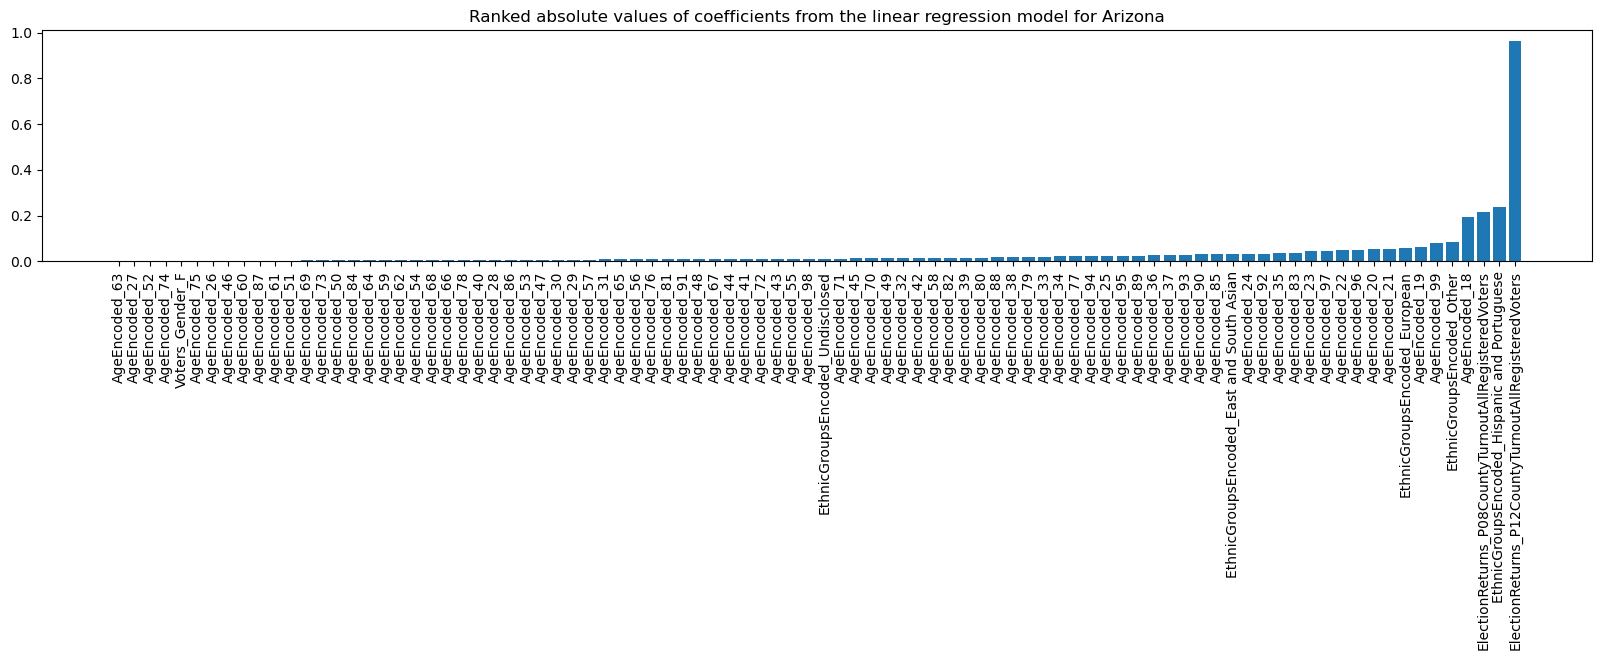

In [26]:
# Retrieving the name of the columns used to make our feature vector and storing them in a pandas DataFrame
featureCols_UT = pd.DataFrame(preparedUT.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  preparedUT.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols_UT = featureCols_UT.set_index('idx')

# Creating a data frame of the coefficients
coefsArray_UT = np.array(lrModel_UT.coefficients)  # convert to np.array
coefsDF_UT = pd.DataFrame(coefsArray_UT, columns=['coefs'])  # to pandas
coefsDF_UT = coefsDF_UT.merge(featureCols_UT, left_index=True, right_index=True)  # join it with featureCols we created above
coefsDF_UT.sort_values('coefs', inplace=True)  # Sort them

# Taking the absolute values of the coefficients (to compare feature importance overall)
coefsDF2_UT = coefsDF_UT
coefsDF2_UT['coefs'] = coefsDF2_UT['coefs'].abs()
coefsDF2_UT.sort_values('coefs', inplace=True)  # Sort them

# Plotting
plt.rcParams["figure.figsize"] = (20,3)

plt.xticks(rotation=90)
plt.bar(coefsDF2_UT.name, coefsDF2_UT.coefs)
plt.title('Ranked absolute values of coefficients from the linear regression model for Arizona')
plt.show() 

The feature importances for Utah seem to be much less spread out than Arizona. Most of the feature importance appears to lie in the `ElectionReturns_P12CountyTurnoutAllRegisteredVoters` variable. However, this still makes intuitive sense for the same reason as we stated for Arizona: if a voter turned out to a previous major election, it is sensible to assume that their turnout to that election may be a great indicator that they will come to the next major election.

Let us now check the model performance on the training data.

In [27]:
# Extracting the summary of our model
summary_UT = lrModel_UT.summary

# Extracting the rmse and r2 of the training data from the summary
LR_rmse_UT_train = summary_UT.rootMeanSquaredError
LR_r2_UT_train = summary_UT.r2

LR_rmse_UT_train, LR_r2_UT_train

(1.2149110072280236, 0.8801762582602575)

The RMSE of 1.2149 is moderately low and the $R^2$ of 0.8802 is moderately high, so the model did relatively well on the training data. However, let us now test the model and compare its performance on the testing data to the training data.

In [28]:
# Testing the model
LRfittedTest_UT = lrModel_UT.transform(testUT)

# Viewing the results of the top 5 rows
LRfittedTest_UT['label', 'prediction'].show(5)

+-----+------------------+
|label|        prediction|
+-----+------------------+
| 24.0|22.274940034405365|
| 24.0| 23.88901690832071|
| 24.0| 23.88901690832071|
| 24.0| 23.88901690832071|
| 24.0| 26.15433486096766|
+-----+------------------+
only showing top 5 rows



It appears the predictions are not too far off the true values, but let us check the RMSE and $R^2$ to verify.

In [29]:
# Finding the rmse and r2 of the model on the testing data (using evaluator defined before)
LR_rmse_UT = LRevaluator.evaluate(LRfittedTest_UT, {LRevaluator.metricName: "rmse"})
LR_r2_UT = LRevaluator.evaluate(LRfittedTest_UT, {LRevaluator.metricName: "r2"})

print(LR_rmse_UT, LR_r2_UT)

1.2162385443915957 0.8798580947414697


It appears the RMSE and $R^2$ of the model on the Utah testing data were in the same range as that of the training data. The RMSE of 1.2162 is still moderately low and the $R^2$ of 0.8799 is still moderately high.

## Random Forest

The next model we will fit is a random forest. A random forest builds decision trees by grouping and dividing the data we train it on and takes the average of each decision tree to improve its predictive accuracy. Essentially, the model predicts the outcome by taking the averages of individual decision trees and finalizing the prediction based on those averages. Random forests often result in higher predictive accuracy than linear models because they are more flexible. The flexibility is traded off with the fact that random forests are more difficult to interpret.

**Arizona**

First, we must index the `Voters_Gender` column in the Arizona data because random forests for regression will not work with categorical data.

In [13]:
# Indexing the Voters_Gender column since it is categorical
featureIndexer = StringIndexer(inputCol = 'Voters_Gender', outputCol = "indexedGender")

# Transforming the data frame with the newly indexed column
AZ_df_new2 = featureIndexer.fit(AZ_df_new).transform(AZ_df_new)

# Dropping the categorical variable
AZ_df_new2 = AZ_df_new2.drop("Voters_Gender")

Now, we assemble a `features` vector that wil encode the values for each of our explanatory variables into one vector.

In [14]:
# Assembling the vector of features we will predict with
featureAssembler = VectorAssembler(inputCols = ['EthnicGroupsEncoded', 'AgeEncoded', 'indexedGender', 'ElectionReturns_P12CountyTurnoutAllRegisteredVoters', 
                                                'ElectionReturns_P08CountyTurnoutAllRegisteredVoters'], outputCol = "features")

# Transforming the data frame to include a features column encoded with the values for these features
AZ_df_new2 = featureAssembler.transform(AZ_df_new2)

Now, we create a training and testing set as we did before, but now we are splitting our raw data.

In [15]:
# Creating training and testing sets
(training_AZ, test_AZ) = AZ_df_new2.randomSplit([0.7, 0.3], seed = 135)

It is finally time to fit and test our random forest!

In [28]:
# Creating a gradient boosted tree model
rf = RandomForestRegressor(featuresCol = "features",
                  labelCol = "ElectionReturns_P16CountyTurnoutAllRegisteredVoters",
                  predictionCol = "predictions",
                  seed = 42)

# Fitting the model to the training data
RFmodel_AZ = rf.fit(training_AZ)

# Testing the model on the testing data
RFfittedTest_AZ = RFmodel_AZ.transform(test_AZ)

Let us take a look at the first couple predictions.

In [17]:
# Looking at the first couple predictions
RFfittedTest_AZ.select("ElectionReturns_P16CountyTurnoutAllRegisteredVoters", "predictions").show(5)

+---------------------------------------------------+------------------+
|ElectionReturns_P16CountyTurnoutAllRegisteredVoters|       predictions|
+---------------------------------------------------+------------------+
|                                               24.0|23.993394468142547|
|                                               24.0|23.610780029459118|
|                                               24.0|23.610780029459118|
|                                               24.0| 24.06790113623466|
|                                               24.0| 24.06790113623466|
+---------------------------------------------------+------------------+
only showing top 5 rows



It appears the predictions are not too far off the true values, but let us check the RMSE and $R^2$ to verify.

In [18]:
# Setting the evaluator object
RF_GBT_evaluator = RegressionEvaluator(labelCol = "ElectionReturns_P16CountyTurnoutAllRegisteredVoters",
                  predictionCol = "predictions")

# Finding the rmse and r2
RF_rmse_AZ = RF_GBT_evaluator.evaluate(RFfittedTest_AZ, {RF_GBT_evaluator.metricName: "rmse"})
RF_r2_AZ = RF_GBT_evaluator.evaluate(RFfittedTest_AZ, {RF_GBT_evaluator.metricName: "r2"})

print(RF_rmse_AZ, RF_r2_AZ)

0.8000436447149896 0.9480428318699825


The RMSE of 0.8000 and the $R^2$ of 0.94 are both better than those of the linear regression, so we can see that the random forest model is a better predictive model for our data. The RMSE is quite low and the $R^2$ is quite high, so we can say our random forest is a good model to predict `ElectionReturns_P16CountyTurnoutAllRegisteredVoters` using our chosen explanatory variables.

**Utah**

Now, we do the same for Utah, starting by dealing with the categorical data.

In [36]:
# Transforming the data frame with the same feature indexer from before
UT_df_new2 = featureIndexer.fit(UT_df_new).transform(UT_df_new)

# Dropping the categorical variable
UT_df_new2 = UT_df_new2.drop("Voters_Gender")

Now, we assemble the features for Utah as we did with Arizona.

In [37]:
# Transforming the data frame to include a features column encoded with the values for these features from before
UT_df_new2 = featureAssembler.transform(UT_df_new2)

Let us also create the training and the testing data for Utah.

In [38]:
# Creating training and testing sets
(training_UT, test_UT) = UT_df_new2.randomSplit([0.7, 0.3], seed = 135)

Now, we may finally fit the random forest model to the Utah training data and test on the testing data!

In [42]:
# Fitting the model to the training data
RFmodel_UT = rf.fit(training_UT)

# Testing the model on the testing data
RFfittedTest_UT = RFmodel_UT.transform(test_UT)

Let us check out the first couple of predictions.

In [43]:
RFfittedTest_UT.select("ElectionReturns_P16CountyTurnoutAllRegisteredVoters", "predictions").show(5)

+---------------------------------------------------+-----------------+
|ElectionReturns_P16CountyTurnoutAllRegisteredVoters|      predictions|
+---------------------------------------------------+-----------------+
|                                               24.0|23.90141599904464|
|                                               24.0| 23.7440274602924|
|                                               24.0| 23.7440274602924|
|                                               24.0| 23.7440274602924|
|                                               24.0| 23.7440274602924|
+---------------------------------------------------+-----------------+
only showing top 5 rows



The predictions do not appear to be too far off of the true values, but let us check the RMSE and $R^2$ to be sure.

In [44]:
# Finding the rmse and r2 using the evaluator defined before
RF_rmse_UT = RF_GBT_evaluator.evaluate(RFfittedTest_UT, {RF_GBT_evaluator.metricName: "rmse"})
RF_r2_UT = RF_GBT_evaluator.evaluate(RFfittedTest_UT, {RF_GBT_evaluator.metricName: "r2"})

print(RF_rmse_UT, RF_r2_UT)

0.7147792724814811 0.9585636351797281


The RMSE of 0.7148 is quite low and the $R^2$ of 0.9586 is quite high and further shows how the random forest is also a better model to predict `ElectionReturns_P16CountyTurnoutAllRegisteredVoters` using our chosen explanatory variables than the linear regression model as we found with Arizona.

## Gradient Boosted Tree

The final model we will be fitting is a gradient boosted tree. The gradient boosted tree is a weak learner in the sense that it fits one tree and then learns from the mistakes of that tree to fit another tree. The model then attempts to create the best predictive tree by learning from the mistakes of the previous tree in the least number of iterations possible. This model tends ot outperform the random forest as it is progressively learning and improving in a stage-wise fashion while the random forest is just one big ensemble of trees that does not improve based on previous results as it moves forward.

**Arizona**

We already have the indexed categorical variables, `features` column, and training/testing data ready from the random forest model. So, we can move straight to fitting the model!

In [46]:
# Creating a gradient boosted tree model
gbt = GBTRegressor(featuresCol = "features",
                  labelCol = "ElectionReturns_P16CountyTurnoutAllRegisteredVoters",
                  predictionCol = "predictions",
                  seed = 42)

# Fitting the model to the training data
GBTmodel_AZ = gbt.fit(training_AZ)

# Testing the model on the testing data
GBTfittedTest_AZ = GBTmodel_AZ.transform(test_AZ)

Let's print out the first couple of predictions.

In [47]:
# Printing first 5 predictions
GBTfittedTest_AZ.select("ElectionReturns_P16CountyTurnoutAllRegisteredVoters", "predictions").show(5)

+---------------------------------------------------+-----------+
|ElectionReturns_P16CountyTurnoutAllRegisteredVoters|predictions|
+---------------------------------------------------+-----------+
|                                               24.0|       24.0|
|                                               24.0|       24.0|
|                                               24.0|       24.0|
|                                               24.0|       24.0|
|                                               24.0|       24.0|
+---------------------------------------------------+-----------+
only showing top 5 rows



The model appears to have perfectly predicted the first 5 true values, but let us check out the RMSE and $R^2$ to get a better picture.

In [48]:
# Finding the rmse and r2 using evaluator from before
GBT_rmse_AZ = RF_GBT_evaluator.evaluate(GBTfittedTest_AZ, {RF_GBT_evaluator.metricName: "rmse"})
GBT_r2_AZ = RF_GBT_evaluator.evaluate(GBTfittedTest_AZ, {RF_GBT_evaluator.metricName: "r2"})

print(GBT_rmse_AZ, GBT_r2_AZ)

0.0 1.0


The gradient boosted tree for the Arizona data had a 0.0 RMSE and 1.0 $R^2$. This means the model perfectly predicted `ElectionReturns_P16CountyTurnoutAllRegisteredVoters` using our chosen explanatory variables. This model also proved to do better than both the linear regression model and the random forest as we expected.

**Utah**

We also already have the same variables ready for Utah as we did for Arizona, so we are also ready to fit the model here as well!

In [49]:
# Fitting the model defined before to the training data for Utah
GBTmodel_UT = gbt.fit(training_UT)

# Testing the model on the testing data for Utah
GBTfittedTest_UT = GBTmodel_UT.transform(test_UT)

Let's look at the first couple of predictions to see how the model did.

In [ ]:
# Printing first 5 predictions
GBTfittedTest_UT.select("ElectionReturns_P16CountyTurnoutAllRegisteredVoters", "predictions").show(5)

+---------------------------------------------------+-----------+
|ElectionReturns_P16CountyTurnoutAllRegisteredVoters|predictions|
+---------------------------------------------------+-----------+
|                                               24.0|       24.0|
|                                               24.0|       24.0|
|                                               24.0|       24.0|
|                                               24.0|       24.0|
|                                               24.0|       24.0|
+---------------------------------------------------+-----------+
only showing top 5 rows



Once again, the gradient boosted tree predicted the first 5 values perfectly, but let's check out the RMSE and $R^2$.

In [51]:
# Finding the rmse and r2 using evaluator object from before
GBT_rmse_UT = RF_GBT_evaluator.evaluate(GBTfittedTest_UT, {RF_GBT_evaluator.metricName: "rmse"})
GBT_r2_UT = RF_GBT_evaluator.evaluate(GBTfittedTest_UT, {RF_GBT_evaluator.metricName: "r2"})

print(GBT_rmse_UT, GBT_r2_UT)

0.0 1.0


The RMSE is 0.0 and the $R^2$ is 1.0 once again. The gradient boosted tree also perfectly predicted the `ElectionReturns_P16CountyTurnoutAllRegisteredVoters` using our chosen explanatory variables for Utah. This model performed better than the linear regression and the random forest on the testing data for both states.

Although the gradient boosted tree appears to have performed extremely well on the testing data for both Utah and Arizona, we must still be cautious about getting 100% perfect predictions. Often, this can be a sign of overfitting on the training data, but that is usually combatted by avoiding fitting on the testing data only only testing on that data (which is what we did). Though it does not appear that we made any errors in building our models, the perfect modeling of the gradient boosted tree is an indication that we should remain cautious of the potential of having had some sort of error or overfitting. If not, this might also mean that the voter turnout data for 2016 by county is a variable that is easily predictable using our set of explanatory variables, which may also explain the perfect modeling of the gradient boosted tree.

We will move forward with our observed RMSE and $R^2$ values for each of the models on the testing data, but we just wanted to to include a discussion of why it may be possibly alarming to have perfect RMSE or $R^2$ values.

# Model Performance Comparisons

Before we move onto plotting any comparisons, let's create some data frames with our RMSE and $R^2$ values for reproducibility.

In [2]:
# Creating a data frame with the final rmse and r2 values for comparison later
# Filling in the values manually so we do not have to rerun the models later

models = ["Linear Regression", "Random Forest", "Gradient Boosted Trees"]
AZ_rmse_values_all = [1.2141, 0.8000, 0.0]
AZ_r2_values_all = [0.8801, 0.9480, 1.0]

UT_rmse_values_all = [1.2162, 0.7148, 0.0]
UT_r2_values_all = [0.8799, 0.9586, 1.0]

# Final data frames
final_df_AZ = pd.DataFrame([["Linear Regression", 1.2141, 0.8801], ["Random Forest", 0.8000, 0.9480], ["Gradient Boosted Tree", 0.0, 1.0]],
                          columns = ['Model', 'RMSE', 'R^2'])
final_df_UT = pd.DataFrame([["Linear Regression", 1.2162, 0.8799], ["Random Forest", 0.7148, 0.9586], ["Gradient Boosted Tree", 0.0, 1.0]],
                          columns = ['Model', 'RMSE', 'R^2'])

Let's see how the models did in comparison to one another for each state.

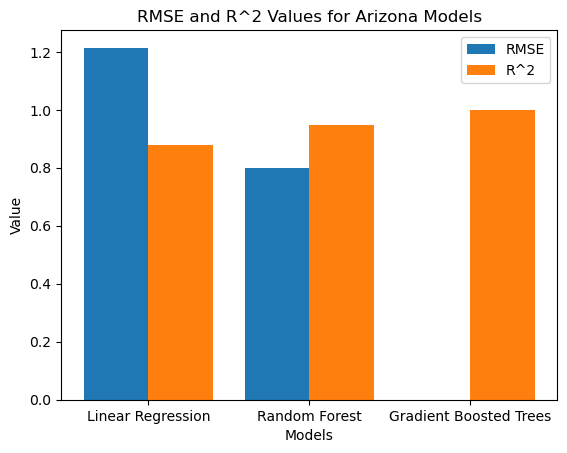

In [9]:
# Plotting the RMSE and R^2 for Arizona
x_axis = np.arange(len(models))

plt.bar(x_axis - 0.2, AZ_rmse_values_all, 0.4, label = "RMSE")
plt.bar(x_axis + 0.2, AZ_r2_values_all, 0.4, label = "R^2")

plt.xticks(x_axis, models)
plt.xlabel("Models")
plt.ylabel("Value")
plt.title("RMSE and R^2 Values for Arizona Models")
plt.legend()
plt.show()

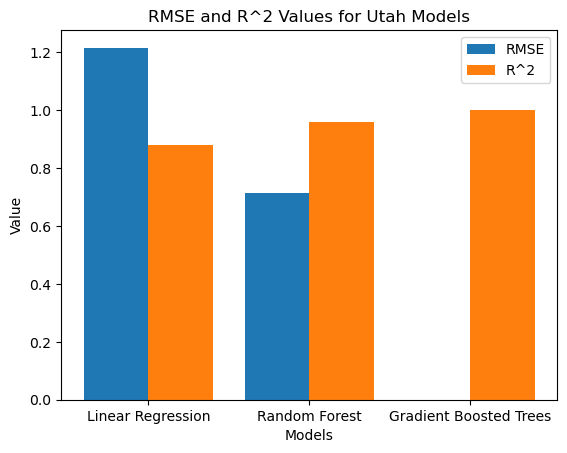

In [6]:
# Plotting the RMSE and R^2 for Utah
x_axis = np.arange(len(models))

plt.bar(x_axis - 0.2, UT_rmse_values_all, 0.4, label = "RMSE")
plt.bar(x_axis + 0.2, UT_r2_values_all, 0.4, label = "R^2")

plt.xticks(x_axis, models)
plt.xlabel("Models")
plt.ylabel("Value")
plt.title("RMSE and R^2 Values for Utah Models")
plt.legend()
plt.show()

From the plots, we can see that the RMSE and $R^2$ values for each of the models for Utah and Arizona are very close to one another if not the same. Also, we can see the trend we observed before: linear regression had the highest RMSE and lowest $R^2$, the random forest had the second highest RMSE and second lowest $R^2$, and the gradient boosted tree had the lowest RMSE and highest $R^2$.

# Conclusion

The three models that were used in this project to predict voter turnout in 2016 by county in Arizona and Utah were linear regression, random forests and gradient boosted trees. These were all regression models since we are looking to predict a continuous outcome instead of a discrete outcome (classification). By looking at the model summaries, we can see that most predictions were around the actual voter turnouts observed in the datasets. More specifically the linear models had R^2 values of about .88 for both states. Furthermore, random forests and gradient boosted trees had higher R^2 values. The gradient boosted trees had R^2 values of 1 for both states. This means the model predicted everything perfectly. It is unlikely that a dataset with large number of observations and features would be able to predict perfectly. This is likely due to gradient boosted trees being prone to overfitting unlike random forests which explains why the gradient boosted tree models predicted perfectly for both Arizona and Utah. Tuning the hyperparameteres would likely help fix overfitting of the gradient boosted tree models.

Although random forests and gradient boosted trees performed better in predicting our outcome, we did learn valuable information from the linear models. We were able to find the that the most important predictor was how turnouts were the election before which makes sense since there would have to a significant change in other varaiables for voter turnouts to change significanty within 4 years. If we were to predict further into the future, a particular variable that could drastically affect turnout rates in such as short time is a pandemic such as COVID-19 where voters might be more or less likely to vote. The next important variable that was consistent in both states is Hispanic and Portugese ethnicity. Outside of California, New Mexico and Texas, the hispanic proportion is the highest in Arizona which explains the predictor influence on voter turnout. Although Utah doesn't have as high of a Hispanic/Portugese proportion (around 15 percent), the proportion is still higher than about half the states in the United States. Furthermore, hispanic ethniity is the most common ethinicty outside of white in both states which explains why Hispanic/Portugese ethnicity ranked highly as a predictor for voter turnout. In our linear model for Utah, Hispanic and Portugese ethnicity ranked third in most important predictor in comparison to Arizona which ranked it second. 

Moreover, it appears the three models have similar performances for the two differing states Arizona and Utah. It is also interesting to note that Arizona is a swing state while Utah has voted Republican 17 out of 18 elections. This could raise further questions such as how is voter turnout affected when voters know the party their state is going to vote for? Other possible revenues of further research could be, as we mentioned before, how the 2020 elections were affected by COVID-19 and if the variable importance differs. 

Overall, our project has revealed important information about the predictability of the voter turnout in 2016 by county in Arizona and Utah as well as the types of variables that affect the voter turnout. We have learned a great deal about what kinds of variables affect voter turnout as well as how to build models to predict such an outcome accurately.

## Sources (outside of data used)

https://worldpopulationreview.com/state-rankings/hispanic-population-by-state

https://worldpopulationreview.com/state-rankings/swing-states